In [1]:
import torch
from torch import optim
from torch import Tensor
from torch import nn

from torch.nn import functional as F
import torchvision.transforms as T 
import matplotlib.pyplot as plt
from PIL import Image

transform = T.ToPILImage()

In [2]:
DATA_PATH = '../../data/'

In [3]:
torch.poisson(torch.rand(4, 4) * 5)

tensor([[ 0.,  1.,  4.,  2.],
        [ 1.,  5.,  1.,  5.],
        [ 1., 10.,  4.,  3.],
        [ 3.,  4.,  3.,  2.]])

In [28]:
path_train = DATA_PATH + 'train_data.pkl'
path_val = DATA_PATH + 'val_data.pkl'

# 2 tensors of size 50000 x 3 x H x W
noisy_imgs_1, noisy_imgs_2 = torch.load(path_train)
noisy_imgs_1_poisson = noisy_imgs_1 + torch.poisson(torch.rand(noisy_imgs_1.size()) * 5) 
noisy_imgs_2_poisson = noisy_imgs_2 + torch.poisson(torch.rand(noisy_imgs_2.size()) * 5) 
noisy_imgs_1_bernoulli = noisy_imgs_1 + torch.bernoulli(torch.empty(noisy_imgs_1.size()).uniform_(0, 1))*5
noisy_imgs_2_bernoulli = noisy_imgs_2 + torch.bernoulli(torch.empty(noisy_imgs_2.size()).uniform_(0, 1))*5

noisy_imgs_1 , noisy_imgs_2 = noisy_imgs_1.float()/255, noisy_imgs_2.float()/255
noisy_imgs_1_poisson , noisy_imgs_2_poisson = noisy_imgs_1_poisson.float()/255, noisy_imgs_2_poisson.float()/255
noisy_imgs_1_bernoulli , noisy_imgs_2_bernoulli = noisy_imgs_1_bernoulli.float()/255, noisy_imgs_2_bernoulli.float()/255

noisy_imgs, clean_imgs = torch.load(path_val)
noisy_imgs , clean_imgs = noisy_imgs.float()/255, clean_imgs.float()/255

print(noisy_imgs_1.size())
print(noisy_imgs_2.size())
print(noisy_imgs_1_poisson.size())
print(noisy_imgs_2_poisson.size())
print(noisy_imgs_1_bernoulli.size())
print(noisy_imgs_2_bernoulli.size())
print(noisy_imgs.size())
print(clean_imgs.size())

torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


In [29]:
blurrer_1 = T.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 0.5))
blurred_1_noisy_imgs_1 = blurrer_1(noisy_imgs_1)
blurred_1_noisy_imgs_2 = blurrer_1(noisy_imgs_2)

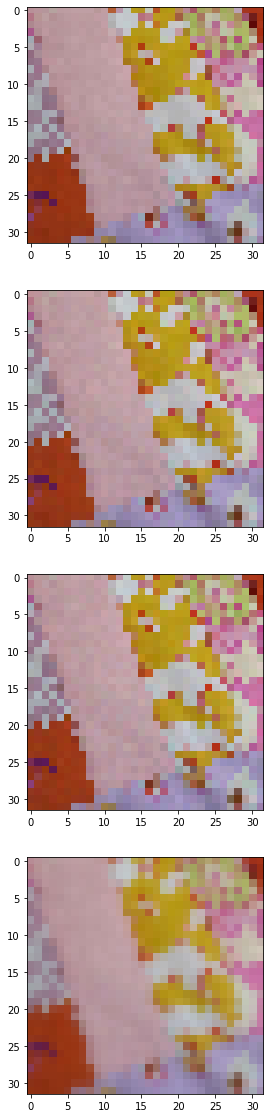

In [30]:
plt.figure(figsize = [20, 20])
plt.subplot(4,1,1)
plt.imshow(transform(noisy_imgs_1[2]));
plt.subplot(4,1,2)
plt.imshow(transform(noisy_imgs_1_poisson[2]));
plt.subplot(4,1,3)
plt.imshow(transform(noisy_imgs_1_bernoulli[2]));
plt.subplot(4,1,4)
plt.imshow(transform(blurred_1_noisy_imgs_1[2]));

In [35]:
train_input = torch.cat((noisy_imgs_1,noisy_imgs_1_poisson,noisy_imgs_1_bernoulli),dim =0)
train_target = torch.cat((noisy_imgs_2,noisy_imgs_2_poisson,noisy_imgs_2_bernoulli),dim =0)

In [39]:
class UNet (nn.Module):
    def __init__(self,in_channels = 3, out_channels = 3):
        '''
        initialize the unet 
        '''
        super(UNet, self).__init__()

        self.encode1 = nn.Sequential(
            nn.Conv2d(in_channels,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        
        self.encode2 = nn.Sequential(
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        
        self.encode3 = nn.Sequential(
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        
        self.encode4 = nn.Sequential(
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        
        self.encode5 = nn.Sequential(
            nn.Conv2d(48,48,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))

        self.decode1 = nn.Sequential(
            nn.Conv2d(96,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(96,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(96,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))

        self.decode2 = nn.Sequential(
            nn.Conv2d(144,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(96,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(96,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        
        self.decode3 = nn.Sequential(
            nn.Conv2d(144,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(96,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(96,96,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        
        self.decode4 = nn.Sequential (
            nn.Conv2d(96 + in_channels,64,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,32,3,stride=1,padding='same'),
            nn.ReLU(inplace=True))
        
        ## output layer
        self.output_layer = nn.Conv2d(32,out_channels,3,stride=1,padding='same')

        ## initialize weight
        self._init_weights()

    def forward(self,x):
        '''
        forward function
        '''
        pool1 = self.encode1(x)
        pool2 = self.encode2(pool1)
        pool3 = self.encode3(pool2)
        pool4 = self.encode4(pool3)
        upsample5 = self.encode5(pool4)
        concat5 = torch.cat((upsample5,pool3),dim=1)
        upsample4 = self.decode1(concat5)
        concat4 = torch.cat((upsample4,pool2),dim=1)
        upsample3 = self.decode2(concat4)
        concat3 = torch.cat((upsample3,pool1),dim=1)
        upsample2 = self.decode3(concat3)
        concat2 = torch.cat((upsample2,x),dim =1)
        umsample0 = self.decode4(concat2)
        output = self.output_layer(umsample0)
        return output
    
    def _init_weights(self):
        """Initializes weights using He et al. (2015)."""
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                nn.init.constant_(m.bias.data, 0)

In [40]:
def psnr(denoised ,ground_truth):
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean ((denoised - ground_truth) ** 2)
  return -10 * torch.log10(mse + 10**-8)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = UNet()
criterion = nn.MSELoss()
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = 1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=True)
train_input, train_target = train_input.to(device).type(torch.float), train_target.to(device).type(torch.float)

nb_epochs = 12
mini_batch_size = 100

model.train()
print("Starting Training Loop...")
for epoch in range(nb_epochs):
    print('-' * 10)
    running_loss = 0.0
    for b in range(0, train_input.size(0), mini_batch_size):
        optim.zero_grad()
        denoised_source = model(train_input.narrow(0, b, mini_batch_size))
        loss = criterion(denoised_source, train_target.narrow(0, b, mini_batch_size))
        loss.backward()
        optim.step() 

        running_loss +=loss.item() * train_target.narrow(0, b, mini_batch_size).size(0)
    epoch_loss = running_loss / len(train_input)
    print('{} Training Loss: {:.4f} PSNR: {:.4f}'.format('current '+ str(epoch), epoch_loss, psnr(clean_imgs.to(device), model(noisy_imgs.to(device)))))

Starting Training Loop...
----------
current 0 Training Loss: 0.0159 PSNR: 24.0515
----------
current 1 Training Loss: 0.0147 PSNR: 24.3290
----------
current 2 Training Loss: 0.0146 PSNR: 24.4207
----------
current 3 Training Loss: 0.0145 PSNR: 24.4603
----------
current 4 Training Loss: 0.0145 PSNR: 24.4658
----------
current 5 Training Loss: 0.0144 PSNR: 24.4717
----------
current 6 Training Loss: 0.0144 PSNR: 24.4210
----------
current 7 Training Loss: 0.0144 PSNR: 24.4581
----------
current 8 Training Loss: 0.0144 PSNR: 24.4428
----------


KeyboardInterrupt: 

In [8]:
torch.save(model.state_dict(), '../../data/bestmodel.pth')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = UNet()
model.load_state_dict(torch.load('../../data/bestmodel.pth'))

<All keys matched successfully>

In [ ]:
plt.imshow(noisy_imgs[15].cpu().permute(1,2,0).numpy())
plt.show()
plt.imshow(clean_imgs[15].cpu().permute(1,2,0).numpy())
plt.show()
tmp=model(noisy_imgs[15:17].to(device)).detach().cpu()
plt.imshow(tmp[0].permute(1,2,0).numpy())
plt.show()